In [1]:
import chess
import copy
import numpy as np
import chess.polyglot
import chess.svg
import chess.pgn
import chess.engine
import dill
# from mpi4py import MPI
from IPython.display import SVG

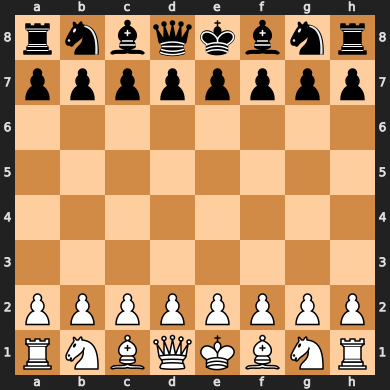

In [2]:
test_board = chess.Board()
test_board

The cell below sets up all the hardcoded tables of values for each piece type. The values represent the "score" that the piece would get by moving to the corresponding square, higher being better in order to entice the pieces to take better positions.

In [2]:
pawntable = [
    0, 0, 0, 0, 0, 0, 0, 0,
    5, 10, 10, -20, -20, 10, 10, 5,
    5, -5, -10, 0, 0, -10, -5, 5,
    0, 0, 0, 20, 20, 0, 0, 0,
    5, 5, 10, 25, 25, 10, 5, 5,
    10, 10, 20, 30, 30, 20, 10, 10,
    50, 50, 50, 50, 50, 50, 50, 50,
    0, 0, 0, 0, 0, 0, 0, 0]

knightstable = [
    -50, -40, -30, -30, -30, -30, -40, -50,
    -40, -20, 0, 5, 5, 0, -20, -40,
    -30, 5, 10, 15, 15, 10, 5, -30,
    -30, 0, 15, 20, 20, 15, 0, -30,
    -30, 5, 15, 20, 20, 15, 5, -30,
    -30, 0, 10, 15, 15, 10, 0, -30,
    -40, -20, 0, 0, 0, 0, -20, -40,
    -50, -40, -30, -30, -30, -30, -40, -50]

bishopstable = [
    -20, -10, -10, -10, -10, -10, -10, -20,
    -10, 5, 0, 0, 0, 0, 5, -10,
    -10, 10, 10, 10, 10, 10, 10, -10,
    -10, 0, 10, 10, 10, 10, 0, -10,
    -10, 5, 5, 10, 10, 5, 5, -10,
    -10, 0, 5, 10, 10, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -10, -10, -10, -10, -20]

rookstable = [
    0, 0, 0, 5, 5, 0, 0, 0,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    5, 10, 10, 10, 10, 10, 10, 5,
    0, 0, 0, 0, 0, 0, 0, 0]

queenstable = [
    -20, -10, -10, -5, -5, -10, -10, -20,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -10, 5, 5, 5, 5, 5, 0, -10,
    0, 0, 5, 5, 5, 5, 0, -5,
    -5, 0, 5, 5, 5, 5, 0, -5,
    -10, 0, 5, 5, 5, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -5, -5, -10, -10, -20]

kingstable = [
    20, 30, 10, 0, 0, 10, 30, 20,
    20, 20, 0, 0, 0, 0, 20, 20,
    -10, -20, -20, -20, -20, -20, -20, -10,
    -20, -30, -30, -40, -40, -30, -30, -20,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30]

In [3]:
def evaluate_board(board, organism=None):
    if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
    if board.is_stalemate():
            return 0
    if board.is_insufficient_material():
            return 0
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    

    material = 100 * (wp - bp) + 320 * (wn - bn) + 330 * (wb - bb) + 500 * (wr - br) + 900 * (wq - bq)

    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq = pawnsq + sum([-pawntable[chess.square_mirror(i)]
                           for i in board.pieces(chess.PAWN, chess.BLACK)])

    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.KNIGHT, chess.BLACK)])

    bishopsq = sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq = bishopsq + sum([-bishopstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.BISHOP, chess.BLACK)])

    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)])
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)]
                           for i in board.pieces(chess.ROOK, chess.BLACK)])

    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)])
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)]
                             for i in board.pieces(chess.QUEEN, chess.BLACK)])

    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)])
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)]
                           for i in board.pieces(chess.KING, chess.BLACK)])
    
    
    if organism == None:
        eval = material + pawnsq + knightsq + bishopsq + rooksq + queensq + kingsq
    else:
        eval = organism.predict(np.array([material, pawnsq, knightsq, bishopsq, rooksq, queensq, kingsq]).reshape((1,-1)))
        
        #compare performance of below
#         if type(eval) is np.ndarray:
#             eval = eval[0][0]
            
        eval = np.array(eval).flatten()
        eval = eval[0]
        
    if board.turn:
        return eval
    else:
        return -eval

The cell below describes a function that selects the best move by using alpha-beta pruning. This function takes in a depth to search to and the current board state and returns the best move found along with its value. 

In [4]:
def selectmove(depth, board, organism=None):
        bestMove = chess.Move.null()
        bestValue = -99999
        alpha = -100000
        beta = 100000
        for move in board.legal_moves:
            board.push(move)
            boardValue = -alphabeta(-beta, -alpha, depth - 1, board, organism)
            if boardValue > bestValue:
                bestValue = boardValue
                bestMove = move
            if (boardValue > alpha):
                alpha = boardValue
            board.pop()
        return (bestMove, bestValue)

The cell below depicts a helper method for the alpha-beta pruning of selecting a best move. 

In [5]:
def alphabeta(alpha, beta, depthleft, board, organism=None):
    bestscore = -9999
    if (depthleft == 0):
        return quiesce(alpha, beta, board, organism)
    for move in board.legal_moves:
        board.push(move)
        score = -alphabeta(-beta, -alpha, depthleft - 1, board, organism)
        board.pop()
        if (score >= beta):
            return score
        if (score > bestscore):
            bestscore = score
        if (score > alpha):
            alpha = score
    return bestscore

In [6]:
def quiesce(alpha, beta, board, organism=None):
    stand_pat = evaluate_board(board, organism)
    if (stand_pat >= beta):
        return beta
    if (alpha < stand_pat):
        alpha = stand_pat

    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiesce(-beta, -alpha, board, organism)
            board.pop()

            if (score >= beta):
                return beta
            if (score > alpha):
                alpha = score
    return alpha

In [9]:
# use this for computer move
mov = selectmove(5, test_board)[0]
test_board.push(mov)

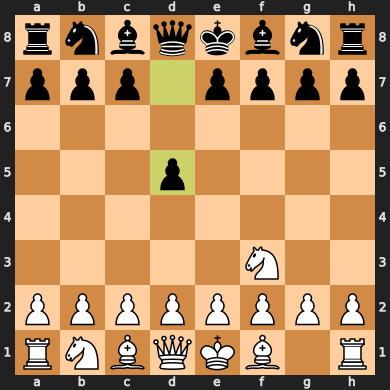

In [10]:
# use this for human move, where e5 is the example move
test_board.push_san("d5")
test_board

# Lets watch a basic alphabeta min max play against stockfish

In [11]:
# count = 0
# movehistory = []
# game = chess.pgn.Game()
# test_board = chess.Board()
# engine = chess.engine.SimpleEngine.popen_uci("./stockfish_15.1_linux_x64/stockfish-ubuntu-20.04-x86-64")

# while not test_board.is_game_over(claim_draw=True):
#     if test_board.turn:
#         count += 1
#         print(f'\n{count}]\n')
#         move = engine.play(test_board, chess.engine.Limit(time=0.1))
#         movehistory.append(move.move)
#         test_board.push(move.move)
#         print(test_board)
#     else:
#         move = selectmove(3, test_board, None)[0]
#         movehistory.append(move)
#         test_board.push(move)
#         print(test_board)
#         game.add_line(movehistory)
        
# game.headers["Result"] = str(test_board.result(claim_draw=True))
# print(game)
# SVG(chess.svg.board(board=test_board, size=400))

In [12]:
# count = 0
# movehistory = []
# game = chess.pgn.Game()
# board = chess.Board()

# while not board.is_game_over(claim_draw=True):
#     if board.turn:
#         count += 1
#         print(f'\n{count}]\n')
#         move = selectmove(1)[0]
#         board.push(move)
#         print(board)
#         print()
#     else:
#         move = selectmove(1)[0]
#         board.push(move)
#         print(board)
#         game.add_line(movehistory)
# game.headers["Event"] = "Self Tournament 2020"
# game.headers["White"] = "Ai"
# game.headers["Black"] = "Ai"
# game.headers["Result"] = str(board.result(claim_draw=True))
# print(game)
# SVG(chess.svg.board(board=board,size=400))

The cell below depicts the Organism class describing the Neural Network. It contains methods for prediction, mutation, and generating offspring.

In [7]:
class Organism:
    def __init__(self, dimensions, use_bias=True, output='softmax'):
        self.score = 0

        self.winner = False

        self.layers = []
        self.biases = []
        self.use_bias = use_bias
        self.output = self._activation(output)
        self.dimensions = dimensions
        for i in range(len(dimensions) - 1):
            shape = (dimensions[i], dimensions[i + 1])
            std = np.sqrt(2 / sum(shape))
            layer = np.random.normal(0, std, shape)
            bias = np.random.normal(0, std, (1, dimensions[i + 1])) * use_bias
            self.layers.append(layer)
            self.biases.append(bias)

    def _activation(self, output):
        if output == 'softmax':
            return lambda X: np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        if output == 'sigmoid':
            return lambda X: (1 / (1 + np.exp(-X)))
        if output == 'linear':
            return lambda X: X
        if output == 'relu':
            return lambda X: max(0, X)

    def predict(self, X):
        if not X.ndim == 2:
            raise ValueError(f'Input has {X.ndim} dimensions, expected 2')
        if not X.shape[1] == self.layers[0].shape[0]:
            raise ValueError(f'Input has {X.shape[1]} features, expected {self.layers[0].shape[0]}')
        for index, (layer, bias) in enumerate(zip(self.layers, self.biases)):
            X = X @ layer + np.ones((X.shape[0], 1)) @ bias
            if index == len(self.layers) - 1:
                X = self.output(X)  # output activation
            else:
                X = np.clip(X, 0, np.inf)  # ReLU

        return X

    def predict_choice(self, X, deterministic=True):
        probabilities = self.predict(X)
        if deterministic:
            return np.argmax(probabilities, axis=1).reshape((-1, 1))
        if any(np.sum(probabilities, axis=1) != 1):
            raise ValueError(f'Output values must sum to 1 to use deterministic=False')
        if any(probabilities < 0):
            raise ValueError(f'Output values cannot be negative to use deterministic=False')
        choices = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            U = np.random.rand(X.shape[0])
            c = 0
            while U > probabilities[i, c]:
                U -= probabilities[i, c]
                c += 1
            else:
                choices[i] = c
        return choices.reshape((-1, 1))

    def mutate(self, stdev=0.03):
        for i in range(len(self.layers)):
            self.layers[i] += np.random.normal(0, stdev, self.layers[i].shape)
            if self.use_bias:
                self.biases[i] += np.random.normal(0, stdev, self.biases[i].shape)

    def mate(self, other, mutate=True):
        if self.use_bias != other.use_bias:
            raise ValueError('Both parents must use bias or not use bias')
        if not len(self.layers) == len(other.layers):
            raise ValueError('Both parents must have same number of layers')
        if not all(self.layers[x].shape == other.layers[x].shape for x in range(len(self.layers))):
            raise ValueError('Both parents must have same shape')

        child = copy.deepcopy(self)
        for i in range(len(child.layers)):
            pass_on = np.random.rand(1, child.layers[i].shape[1]) < 0.5
            child.layers[i] = pass_on * self.layers[i] + ~pass_on * other.layers[i]
            child.biases[i] = pass_on * self.biases[i] + ~pass_on * other.biases[i]
        if mutate:
            child.mutate()
        return child

    def save_human_readable(self, filepath):
        file = open(filepath, 'w')
        file.write('----------NEW MODEL----------\n')
        file.write('DIMENSIONS\n')
        for dimension in self.dimensions:
            file.write(str(dimension) + ',')
        file.write('\nWEIGHTS\n')
        for layer in self.layers:
            file.write('NEW LAYER\n')
            for node in layer:
                for weight in node:
                    file.write(str(weight) + ',')
                file.write('\n')
            file.write('\n')
        if self.use_bias:
            file.write('BIASES:\n')
            for layer in self.biases:
                file.write('\nNEW LAYER\n')
                for connection in layer:
                    file.write(str(connection) + ',')
        file.close()

    def save(self, filepath):
        with open(filepath, 'wb') as file:
            dill.dump(self, file)

    @staticmethod
    def load(filepath):
        with open(filepath, 'rb') as file:
            organism = dill.load(file)
        return organism

In [8]:
def pairwise(iterable):
    # s -> (s0, s1), (s2, s3), (s4, s5), ...
    a = iter(iterable)
    return zip(a, a)

The cell below depicts the environment that houses all the instances of the Organisms. This serves as the population for the genetic algorithm side of things. It contains methods to generate a generation, and return the best Organism within a generation.

In [10]:
class Ecosystem():
    def __init__(self, orginism_creator, scoring_function, population_size=100, holdout='sqrt', mating=True):
        """
        origanism_creator must be a function to produce Organisms, used for the original population
        scoring_function must be a function which accepts an Organism as input and returns a float
        """
        self.population_size = population_size
        
        self.population = [organism_creator() for _ in range(population_size)]
        self.mating = mating
        
        self.rewards = []
        
        self.scoring_function = scoring_function
        if holdout == 'sqrt':
            self.holdout = max(1, int(np.sqrt(population_size)))
        elif holdout == 'log':
            self.holdout = max(1, int(np.log(population_size)))
        elif holdout > 0 and holdout < 1:
            self.holdout = max(1, int(holdout * population_size))
        else:
            self.holdout = max(1, int(holdout))
            
    def generation(self, repeats=1, keep_best=True):
        self.rewards = [self.scoring_function(x, y) for x, y in pairwise(self.population)]
       # print("Before flatten, ", self.rewards)
        self.rewards = [item for sublist in self.rewards for item in sublist]
        #print("After flatten, ", self.rewards)

        
        self.population = [self.population[x] for x in np.argsort(self.rewards)[::-1]]
        self.population_size = len(self.population)
        
#         self.population_new = [pop for pop in self.population if pop.winner]
        
#         if(len(self.population_new) > 2):
#             self.population = self.population_new
#             self.population_size = len(self.population)
            
        
        new_population = []
        for i in range(self.population_size):
            parent_1_idx = i % self.holdout
            #print(parent_1_idx)
        
            if self.mating:
                parent_2_idx = min(self.population_size - 1, int(np.random.exponential(self.holdout)))
            else:
                parent_2_idx = parent_1_idx
            offspring = self.population[parent_1_idx].mate(self.population[parent_2_idx])
            new_population.append(offspring)
        if keep_best:
            new_population[-1] = self.population[0] # Ensure best organism survives
        self.population = new_population
        # return -1 * max(rewards)
        
        
    def mpi_generation(self):
        
        
        if rank > 0:
            comm.Send(local_results, dest=0, tag=14)  # send results to process 0
        else:
            final_results = np.copy(local_results)  # initialize final results with results from process 0
            for i in range(1, size):  # determine the size of the array to be received from each process
                if i < remainder:
                    rank_size = count + 1
                else:
                    rank_size = count
                tmp = np.empty((rank_size, final_results.shape[1]), dtype=np.float)  # create empty array to receive results
                comm.Recv(tmp, source=i, tag=14)  # receive results from the process
                final_results = np.vstack((final_results, tmp))  # add the received results to the final results
            print("results")
            print(final_results)

    def get_best_organism(self, repeats=1, include_reward=False):   
       # rewards = [np.mean(self.scoring_function(x)) for _ in range(repeats) for x in self.population]
        if include_reward:
            best = np.argsort(self.rewards)[-1]
            return self.population[best], self.rewards[best]
        else:
            return self.population[np.argsort(self.rewards)[-1]]

In [14]:
organism_creator = lambda : Organism([7, 32, 8, 1], output='relu')

In [15]:
def captured_piece(board, move, scale=10):
    piece = None
    
    if board.is_capture(move):
        if board.is_en_passant(move):
            piece = chess.PAWN
        else:
            piece = board.piece_at(move.to_square).piece_type
            
            
    if piece is not None:
        if piece is chess.PAWN:
            return scale
        elif piece is chess.KNIGHT or piece is chess.BISHOP:
            return 3 * scale
        elif piece is chess.ROOK:
            return 5 * scale
        elif piece is chess.QUEEN:
            return 9 * scale
    else:
        return 0

The cell below describes a function to simulate a chess game between 2 Organisms.

In [16]:
def simulate_and_evaluate(organism_1, organism_2, print_game=False, trials=1):
    board = chess.Board()
    
    total_points_player_1 = 0
    total_points_player_2 = 0
    winner_points = 0
    loser_points = 0
    
    #The points you get for winning
    WON_POINTS = 10000000
    
    for i in range(trials):
        
        count = 0

        if print_game:
            print("###################################### STARTING NEW GAME ###########################################")
        while not board.is_game_over(claim_draw=False):
            if board.turn:
                count += 1
                if(print_game):
                    print(f'\n{count}]\n')
                #FIRST turn
                move = selectmove(3, board, organism_1)
                total_points_player_1 = total_points_player_1 + move[1]
                
                total_points_player_1 = total_points_player_1 + captured_piece(board, move[0], scale=10)
                
            
                if(print_game):
                    print("Player 1 move")
                    print(move[0])
                board.push(move[0])
                if print_game:
                    print(board)
                    print()
            else:
                #second turn
                move = selectmove(3, board, organism_2)
                total_points_player_2 = total_points_player_2 + -1 * move[1]
                
                total_points_player_2 = total_points_player_2 + captured_piece(board, move[0], scale=10)
                
                if(print_game):
                    print("Player 2 move")
                    print(move[0])
                board.push(move[0])
                if print_game:
                    print(board)
            if print_game:
                print(board.outcome())
                print(total_points_player_1, " player 1 points found so far")
                print(total_points_player_2, " player 2 points found so far")
                
    if board.outcome().result() != "1/2-1/2":
        if board.outcome().result() == "1-0" :
            organism_1.winner = True
            print("Organism 1 won")
            total_points_player_1 = total_points_player_1 + WON_POINTS
        else:
            organism_2.winner = True
            print("Organism 2 won")
            total_points_player_2 = total_points_player_2 + WON_POINTS
    else:
        print("Draw")
        
    # print([total_points_player_1 / trials, total_points_player_2 / trials])
    return [total_points_player_1 / trials, total_points_player_2 / trials]

In [17]:
scoring_function = lambda organism_1, organism_2 : simulate_and_evaluate(organism_1, organism_2, print_game=False, trials=1)
ecosystem = Ecosystem(organism_creator, scoring_function, population_size=30, holdout=0.1, mating=True)

In [ ]:
generations = 20
best_ai_list = []
best_ai_models = []

print("Starting simulations")

for i in range(generations):
    print("Starting generation", i + 1)
    ecosystem.generation()
    best_ai = ecosystem.get_best_organism(repeats=1, include_reward=True)
    #ecosystem.get_best_organism().save("model.txt")
    best_ai_models.append(best_ai[0])
    #     best_ai_list.append(best_ai[1])
    #     print("Best AI = ", best_ai[1])

Starting simulations
Starting generation 1
Draw
Draw
Draw
Draw
Draw
Draw
Organism 2 won
Organism 1 won
Draw
Draw
Draw
Draw
Draw
Draw
Draw
Starting generation 2
Draw
Draw
Draw
Draw
Draw
Organism 2 won
Draw
Draw
Draw
Organism 1 won
Organism 2 won
Draw
Draw
Organism 2 won
Draw
Starting generation 3
Draw
Draw
Draw
Draw
Draw


Have the best ai that we saved fight stockfish. If we can play against stockfish for 20 turns then we would have done better than not using a NN


1]

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
 
r . b q k b n r
p p p p p p p p
. . n . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

2]

r . b q k b n r
p p p p p p p p
. . n . . . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R
 
r . b q k b n r
p p p p . p p p
. . n . p . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

3]

r . b q k b n r
p p p p . p p p
. . n . p . . .
. . . . . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R
 
r . b q k . n r
p p p p . p p p
. . n . p . . .
. . . . . . . .
. b . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R

4]

r . b q k . n r
p p p p . p p p
. . n . p . . .
. . . . . . . .
. b . P P . . .
. . P . . N . .
P P . . . P P P
R N B Q K B . R
 
r . b q k b n r
p p p p . p p p
. . n . p . . .
. . . . . . . .
. . . P P . 

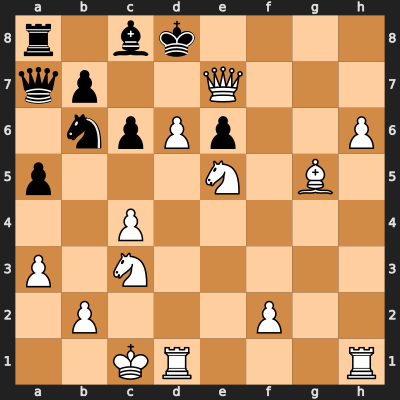

In [9]:
count = 0
movehistory = []
game = chess.pgn.Game()
test_board = chess.Board()
organism_subject = Organism.load("model.pkl")
# un-pickle and put the organism in here ^
engine = chess.engine.SimpleEngine.popen_uci("./stockfish_15.1_linux_x64/stockfish-ubuntu-20.04-x86-64")

while not test_board.is_game_over(claim_draw=True):
    if test_board.turn:
        count += 1
        print(f'\n{count}]\n')
        move = engine.play(test_board, chess.engine.Limit(time=0.1))
        movehistory.append(move.move)
        test_board.push(move.move)
        print(test_board)
        print(" ")
    else:
        move = selectmove(3, test_board, organism_subject)[0]
        movehistory.append(move)
        test_board.push(move)
        print(test_board)
        game.add_line(movehistory)
        
game.headers["Result"] = str(test_board.result(claim_draw=True))
print(game)
SVG(chess.svg.board(board=test_board, size=400))

In [15]:
# Remaining imports
import traceback
from flask import Flask, Response, request
import webbrowser

organism_subject = Organism.load("model-Copy1.pkl")

# Searching Ai's Move
def aimove():
    move = selectmove(3, board, organism_subject)
    board.push(move[0])
    # Searching Stockfish's Move
def stockfish():
    engine = chess.engine.SimpleEngine.popen_uci("./stockfish_15.1_win_x64_popcnt/stockfish-windows-2022-x86-64-modern.exe")
    move = engine.play(board, chess.engine.Limit(time=0.1))
    
    board.push(move.move)
    
app = Flask(__name__)# Front Page of the Flask Web Page
@app.route("/")
def main():
    global count, board
    ret = '<html><head>'
    ret += '<style>input {font-size: 20px; } button { font-size: 20px; }</style>'
    ret += '</head><body>'
    ret += '<img width=510 height=510 src="/board.svg?%f"></img></br></br>' 
    ret += '<form action="/game/" method="post"><button name="New Game" type="submit">New Game</button></form>'
    ret += '<form action="/undo/" method="post"><button name="Undo" type="submit">Undo Last Move</button></form>'
    ret += '<form action="/move/"><input type="submit" value="Make Human Move:"><input name="move" type="text"></input></form>'
    ret += '<form action="/dev/" method="post"><button name="Comp Move" type="submit">Make GA AI Move</button></form>'
    ret += '<form action="/engine/" method="post"><button name="Stockfish Move" type="submit">Make Stockfish Move</button></form>'
    return ret

# Display Board
@app.route("/board.svg/")
def board():
    return Response(chess.svg.board(board=board, size=700), mimetype='image/svg+xml')

# Human Move
@app.route("/move/")
def move():
    try:
        move = request.args.get('move', default="")
        board.push_san(move)
    except Exception:
        traceback.print_exc()
    return main()

# Make Ai’s Move
@app.route("/dev/", methods=['POST'])
def dev():
    try:
        aimove()
    except Exception:
        traceback.print_exc()
    return main()

# Make UCI Compatible engine's move
@app.route("/engine/", methods=['POST'])
def engine():
    try:
        stockfish()
    except Exception:
        traceback.print_exc()
    return main()

# New Game
@app.route("/game/", methods=['POST'])
def game():
    board.reset()
    return main()

# Undo
@app.route("/undo/", methods=['POST'])
def undo():
    try:
        board.pop()
    except Exception:
        traceback.print_exc()
    return main()

In [16]:
#This will not work on rosie, but will work on local machines
board = chess.Board()
#type out square with piece on it and then desired square location with no spaces
#ie e2e4 for kings pawn opener
webbrowser.open("http://127.0.0.1:5000/")
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [16/May/2023 23:19:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:16] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:18] "POST /dev/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:18] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:20] "POST /dev/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:20] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:25] "POST /engine/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:25] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:26] "POST /dev/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:26] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:29] "POST /dev/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:29] "GET /board.svg/?%f HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:31] "POST /dev/ HTTP/1.1" 200 -
127.0.0.1 - - [16/May/2023 23:19:31] "GET /board.